In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import pyodbc

In [117]:
DB = {
    "servername" : r"VISSIE\SQLEXPRESS",
    "database" : "SDM"}

export_conn = pyodbc.connect(f"""DRIVER={'SQL SERVER'};
                             SERVER={DB['servername']};
                             DATABASE={DB['database']};
                             Trusted_Connection=yes
                             """)

export_conn.setencoding('utf-8')
export_conn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-8')
export_conn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf-8')

export_cursor = export_conn.cursor()

In [118]:
def create_dataframes_sql(connection, db_type : str):
    dictionary : dict = {}
    query : str = ""
    key : str = ""
    
    if (db_type == "sqlite"):
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        key = "name"
    elif (db_type == "ssms"):
        query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
        key = "TABLE_NAME"
    else:
        return {}
    table_names = pd.read_sql(query, connection)
    
    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)
    
    return dictionary

sdm = create_dataframes_sql(export_conn, "ssms")

sdm["order_details"]

orders = pd.merge(sdm["order_details"], sdm["returned_item"], left_on="ORDER_DETAIL_CODE", right_on="ORDER_DETAIL_CODE", how="outer")
#orders = pd.merge(orders, sdm["return_reason"], left_on="RETURN_REASON_CODE", right_on="RETURN_REASON_CODE", how="outer")

orders = orders.drop("RETURN_DATE", axis=1).dropna()

orders

C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_34880\2208422301.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  table_names = pd.read_sql(query, connection)
C:\Users\jdvis_x5odeao\AppData\Local\Temp\ipykernel_34880\2208422301.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)


,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_CODE,RETURN_REASON_CODE,RETURN_QUANTITY
6,47743,1529,1,104,4.38,6.59,6.59,1561.0,3.0,104.0
18,47755,1525,2,44,9.64,12.53,12.53,1562.0,2.0,4.0
30,47767,1167,4,84,5.23,7.32,6.80,1564.0,2.0,6.0
39,47776,1472,5,52,38.40,54.93,54.93,1565.0,3.0,52.0
46,47783,1415,6,20,92.00,129.72,129.72,1566.0,4.0,20.0
...,...,...,...,...,...,...,...,...,...,...
37631,115101,7630,13,106,392.57,529.98,461.29,2453.0,2.0,10.0
37656,115142,7631,30,94,6.75,13.50,13.50,2456.0,1.0,10.0
37657,115144,7631,31,240,7.50,15.00,13.84,2457.0,2.0,8.0
37686,115189,7627,60,82,10.00,20.00,15.00,2463.0,1.0,4.0


In [119]:
X = orders.drop('RETURN_REASON_CODE', axis = 1)
y = orders.loc[:, ['RETURN_REASON_CODE']]
X

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_CODE,RETURN_QUANTITY
6,47743,1529,1,104,4.38,6.59,6.59,1561.0,104.0
18,47755,1525,2,44,9.64,12.53,12.53,1562.0,4.0
30,47767,1167,4,84,5.23,7.32,6.80,1564.0,6.0
39,47776,1472,5,52,38.40,54.93,54.93,1565.0,52.0
46,47783,1415,6,20,92.00,129.72,129.72,1566.0,20.0
...,...,...,...,...,...,...,...,...,...
37631,115101,7630,13,106,392.57,529.98,461.29,2453.0,10.0
37656,115142,7631,30,94,6.75,13.50,13.50,2456.0,10.0
37657,115144,7631,31,240,7.50,15.00,13.84,2457.0,8.0
37686,115189,7627,60,82,10.00,20.00,15.00,2463.0,4.0


In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state=42
)

In [121]:
list(X.columns)

['ORDER_DETAIL_CODE',
 'ORDER_NUMBER',
 'PRODUCT_NUMBER',
 'QUANTITY',
 'UNIT_COST',
 'UNIT_PRICE',
 'UNIT_SALE_PRICE',
 'RETURN_CODE',
 'RETURN_QUANTITY']

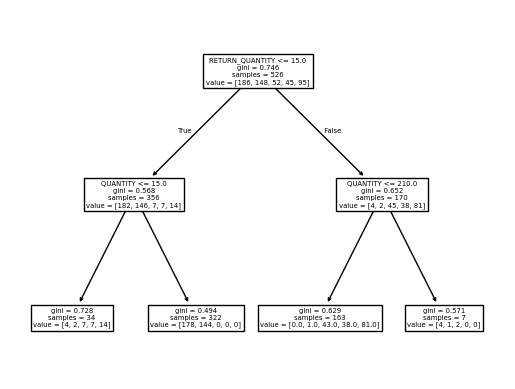

In [122]:
dtree = DecisionTreeClassifier(max_depth = 2)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [123]:
def predict(X_test, y_test, predict_column_name, y_column_name):
    predicted_df = pd.DataFrame(dtree.predict(X_test))
    predicted_df = predicted_df.rename(columns = {0 : predict_column_name})
    return pd.concat([y_test.reset_index()[y_column_name], predicted_df], axis = 1)

In [124]:
model_results_frame = predict(X_test, y_test, "Predicted_Returned_Code", "RETURN_REASON_CODE")
model_results_frame

,RETURN_REASON_CODE,Predicted_Returned_Code
0,3.0,5.0
1,3.0,5.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,1.0


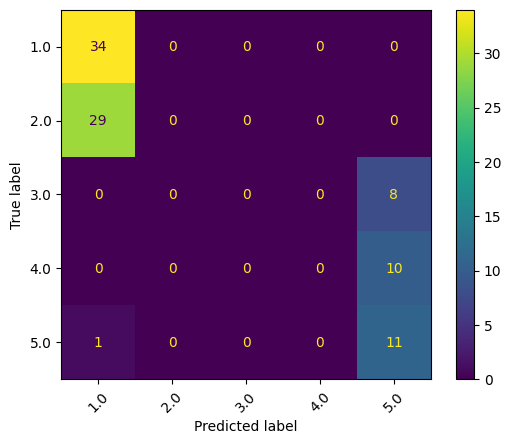

In [125]:
labels = sorted(model_results_frame['RETURN_REASON_CODE'].unique())

confusion_matrix = metrics.confusion_matrix(
    model_results_frame['RETURN_REASON_CODE'],
    model_results_frame['Predicted_Returned_Code']
)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()


In [126]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Returned_Code'])

0.4838709677419355

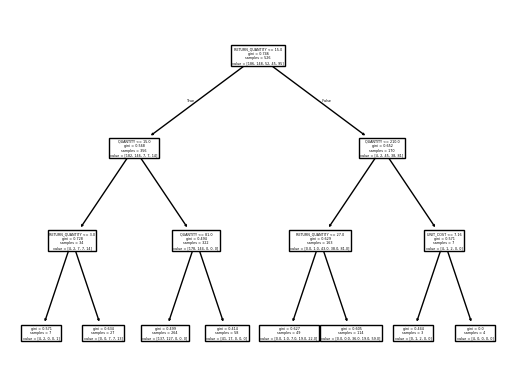

In [127]:
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [128]:
model_results_frame = predict(X_test, y_test, "Predicted_Returned_Code", "RETURN_REASON_CODE")
model_results_frame

,RETURN_REASON_CODE,Predicted_Returned_Code
0,3.0,5.0
1,3.0,5.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,1.0


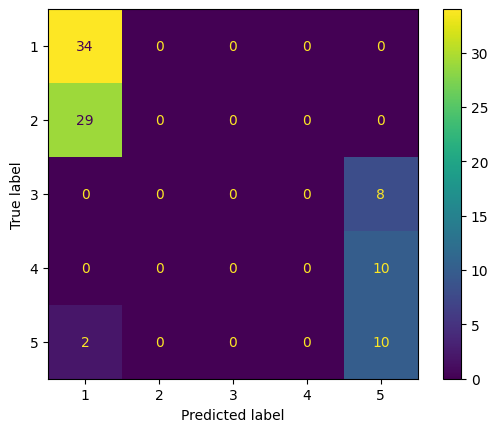

In [129]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Returned_Code'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [130]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Returned_Code'])

0.4731182795698925

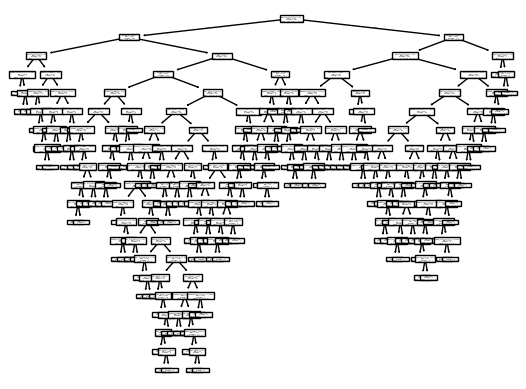

In [131]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [132]:
model_results_frame = predict(X_test, y_test, "Predicted_Returned_Code", "RETURN_REASON_CODE")
model_results_frame

,RETURN_REASON_CODE,Predicted_Returned_Code
0,3.0,5.0
1,3.0,5.0
2,1.0,1.0
3,1.0,1.0
4,1.0,2.0
...,...,...
88,2.0,1.0
89,1.0,2.0
90,1.0,2.0
91,1.0,1.0


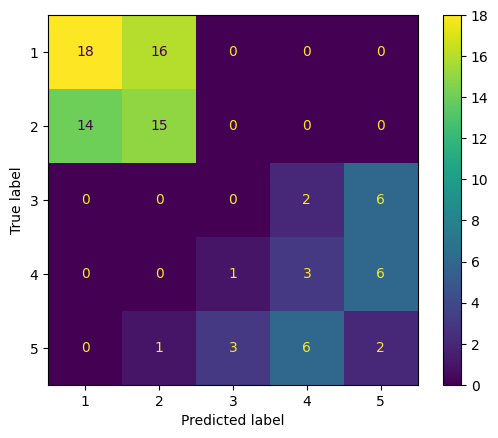

In [133]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Returned_Code'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [134]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Returned_Code'])

0.40860215053763443